In [90]:
!pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()

from fastai.vision.widgets import *

# Convolutional Networks

### CS 356 Week 4 Day 1

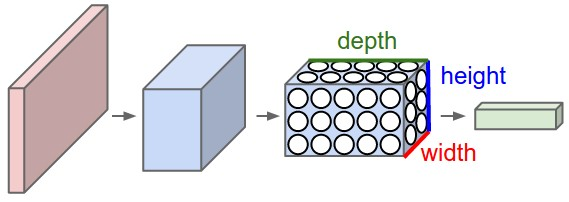

Image source https://cs231n.github.io/convolutional-networks/

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/defreez/cs356-notebooks/blob/main/notebooks/week4-day1.ipynb)

https://muellerzr.github.io/fastblog/2021/02/14/Pytorchtofastai.html

# Convolutions

- Applies a *kernel* to an image
- Reduces the number of parameters in the model
- Learns features, e.g. edges of an object

Great visualization at https://setosa.io/ev/image-kernels/

## Applying kernels

- Let's start by seeing how kernels are applied
- Use MNIST

In [185]:
mnist_path = untar_data(URLs.MNIST)
def get_dls(path, bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

mnist_dls = get_dls(mnist_path)

### PyTorch Convolutions

- `F.conv2d`
- Wants a rank-4 tensor
- Can apply convolutions over an entire batch
- Can apply multiple kernels


- input:: input tensor of shape `(minibatch, in_channels, iH, iW)`
- weight:: filters of shape `(out_channels, in_channels, kH, kW)`

In [93]:
xb,yb = first(mnist_dls.valid)
xb, yb = to_cpu(xb), to_cpu(yb)
xb.shape

torch.Size([64, 1, 28, 28])

In [94]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([2, 3, 3])

- Dimensions don't match, this is rank-3 tensor
- Need to indicate that the kernels have 1 channel

In [95]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([2, 3, 3]), torch.Size([2, 1, 3, 3]))

#### Applying the convolution

- PyTorch function is F.conv2d
- Note that we are applying convolution over an entire batch!
     - Another way that batch size impacts training

In [96]:
batch_features = F.conv2d(xb, edge_kernels.unsqueeze(1))
batch_features.shape

torch.Size([64, 2, 26, 26])

- We get 64 images back out
- 2 kernels back out
- 26x26 out because we lost a pixel

(<AxesSubplot:>, <AxesSubplot:>)

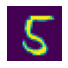

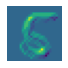

In [97]:
show_image(xb[0]), show_image(batch_features[0,0])

## Padding

- It seems really silly that we would lose a pixel on the edge
- But there is no data there
- Zero padding (replace with zeroes)
- Reflection padding
- Mean value
- ...

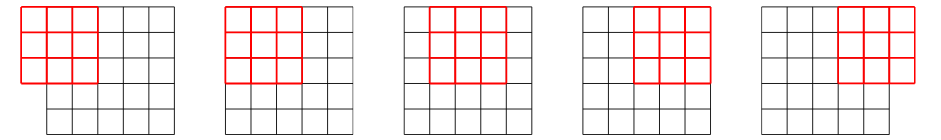

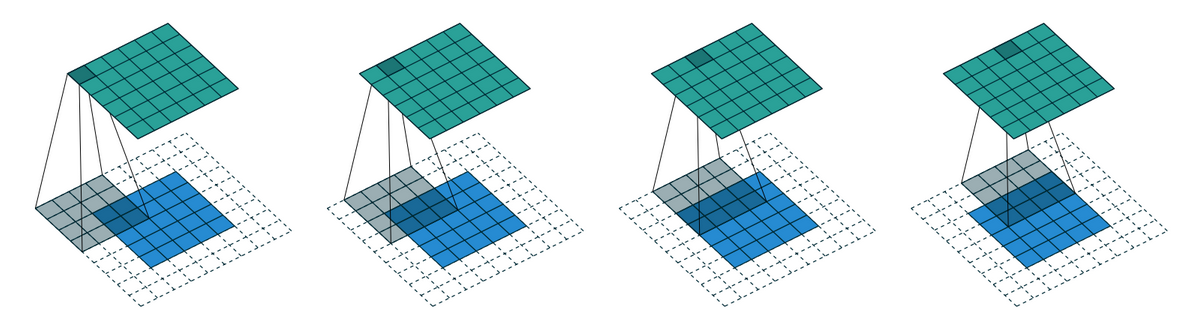

### Padding with Stride

- For kernels with odd length, with padding is kernel size // 2

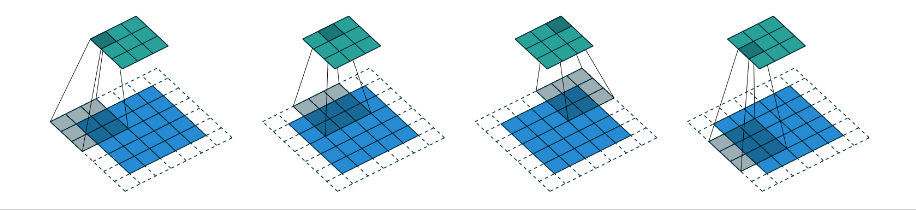

### CNNs from different viewpoints

- Great visualization of CNNs

https://medium.com/impactai/cnns-from-different-viewpoints-fab7f52d159c

## The Lab 2 Network

In [110]:
fashion_path = untar_data('https://sou.box.com/shared/static/twlmuvbz5hjv5530aljkv76gi009s4es.tar')

In [121]:
train_images = get_image_files(fashion_path/'train')
train_x_list = [tensor(Image.open(img_path)).cuda() for img_path in train_images]
train_y_list = [int(img_path.parent.name) for img_path in train_images]
train_x = ((torch.stack(train_x_list)).float()/255).view(-1, 28 * 28)
train_y = tensor(train_y_list).cuda().view(-1, 1)

train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [122]:
train_dset = list(zip(train_x, train_y))

In [123]:
valid_images = get_image_files(fashion_path/'test')
valid_x_list = [tensor(Image.open(img_path)).cuda() for img_path in valid_images]
valid_y_list = [int(img_path.parent.name) for img_path in valid_images]
valid_x = (torch.stack(valid_x_list).float()/255).view(-1, 28*28)
valid_y = tensor(valid_y_list).cuda().view(-1,1)

valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [124]:
valid_dset = list(zip(valid_x, valid_y))

In [158]:
train_dl = DataLoader(train_dset, batch_size=64)

In [159]:
def mnist_loss(pred, actual):
    l = nn.CrossEntropyLoss()
    return l(pred, actual.squeeze())

def calc_grad(xb, yb, model):
    pred = model(xb)
    loss = mnist_loss(pred, yb)
    loss.backward()
    return loss

def batch_accuracy(pred, actual):
    digit_pred = pred.max(dim=1)[1]
    return (digit_pred == actual.squeeze()).float().mean()

def train_epoch(model, optimizer):
    batch_loss = []
    for xb, yb in train_dl:
        batch_loss.append(calc_grad(xb, yb, model))
        optimizer.step()
        optimizer.zero_grad()
    return tensor(batch_loss).mean()

class BasicOptim:
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr
    
    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.lr
            
    def zero_grad(self):
        for p in self.params:
            p.grad = None
            


In [194]:
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
).cuda()

In [195]:
o = BasicOptim(simple_net.parameters(), lr=0.005)

def train_model(model, epochs, opt):
    for i in range(epochs):
        avg_bl = train_epoch(model, opt)
        print(i, avg_bl.item(), batch_accuracy(model(valid_x), valid_y).item())

In [161]:
train_model(simple_net, 10, o)

0 0.19185903668403625 0.1809999942779541
1 0.18312177062034607 0.1809999942779541
2 0.1769765466451645 0.21079999208450317
3 0.17218442261219025 0.2418999969959259
4 0.16763198375701904 0.2505999803543091
5 0.16439752280712128 0.2563999891281128
6 0.1619729846715927 0.26100000739097595
7 0.16115954518318176 0.26409998536109924
8 0.16136951744556427 0.26729997992515564
9 0.1629619002342224 0.2667999863624573


In [157]:
simple_net(valid_x[2]), valid_y[2]

(tensor([-2.8436, -2.0293, -6.8731, -9.5859, -5.8508,  6.6932, -1.0856,  9.3082,  5.9731,  5.9862], device='cuda:0', grad_fn=<AddBackward0>),
 tensor([7], device='cuda:0'))

## Fashion MNIST simple_net with data loaders

In [196]:
def get_fashion_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('train','test'),
        get_y=parent_label
    ).dataloaders(fashion_path, bs=bs)

fashion_dls = get_fashion_dls()

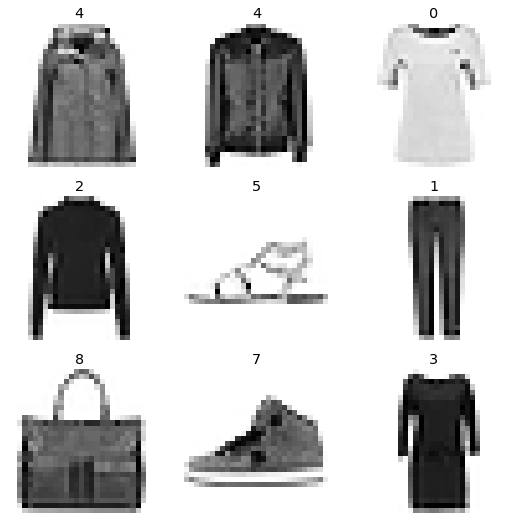

In [197]:
fashion_dls.show_batch()

In [198]:
fashion_simple_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
).cuda()

- Notice the Flatten() layer
- Required to line up up dimensions coming from FastAI loaders and a linear network
- In Lab 2 we did this manually during tensor stacking
- By default FastAI loaders keep images as rank-2 tensors

In [200]:
fashion_simple_learn = Learner(fashion_dls, fashion_simple_net, loss_func=F.cross_entropy, metrics=accuracy)

In [201]:
fashion_simple_learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
Flatten                                                        
____________________________________________________________________________
                     64 x 100            
Linear                                    78500      True      
ReLU                                                           
Linear                                    10100      True      
ReLU                                                           
____________________________________________________________________________
                     64 x 30             
Linear                                    3030       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 10             
Linear                                    310        True   

In [192]:
fashion_simple_learn.fit(10, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.452540,0.482072,0.827100,00:14
1,0.423305,0.444539,0.842500,00:14
2,0.376996,0.460058,0.846600,00:14
3,0.384076,0.404670,0.859500,00:14
4,0.382767,0.427895,0.854200,00:14
5,0.394071,0.461580,0.849200,00:14
6,0.373484,0.406760,0.855100,00:14
7,0.369660,0.437553,0.859800,00:14
8,0.343251,0.410214,0.861900,00:14
9,0.350747,0.413051,0.859500,00:14


## Fashion MNIST conv net

## Simple CNN

- Replacement for simple_net but now with convolution layers
- Convolution is applied automatically
    - Do not need to Flatten
    - Do not need to specify input size

### First Attempt

In [203]:
broken_cnn = nn.Sequential(
    # Learn 30 channels (kernels)
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    # Still need nonlinearity between layers
    nn.ReLU(),
    # Collapse 30 channels
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)

In [204]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

- Problem is that output shape of convolution will be 28x28
- One channel per pixel
- We want one output total (the classification)
- Use Flatten() at the end

### Strides

- Instead of moving the center of the kernel over 1 pixel every time
- Move the center of the kernel over by 2 (or more pixels)
    - Number of pixels is called the stride length
- Stride of 2 cuts size of image in half
- When reducing the size of the image, balanced by increasing the channels (# kernels)

In [106]:
simple_fashion_cnn = nn.Sequential(
    # 28x28 -> 14x14 after this layer
    nn.Conv2d(1, 4, stride=2, kernel_size=3, padding=1),
    nn.ReLU(),
    
    # 7x7 after this layer
    nn.Conv2d(4, 8, stride=2, kernel_size=3, padding=1),
    nn.ReLU(),
    
    # 4x4 after this layer
    nn.Conv2d(8, 16, stride=2, kernel_size=3, padding=1),
    nn.ReLU(),
    
    #2x2 after this layer
    nn.Conv2d(16, 32, stride=2, kernel_size=3, padding=1),
    nn.ReLU(),
    
    #1x10 after this layer
    nn.Conv2d(32, 10, stride=2, kernel_size=3, padding=1),
    
    # Turn into rank-1 tensor of 10 activations.
    Flatten()
)

In [167]:
fashion_learn = Learner(fashion_dls, simple_fashion_cnn, loss_func=F.cross_entropy, metrics=accuracy)

SuggestedLRs(valley=0.0012022644514217973)

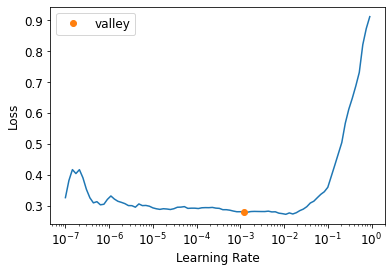

In [168]:
fashion_learn.lr_find()

In [165]:
fashion_learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                                        

In [166]:
fashion_learn.fit(10, 0.002)

epoch,train_loss,valid_loss,accuracy,time
0,0.516623,0.521055,0.803400,00:17
1,0.415132,0.421862,0.844000,00:17
2,0.374888,0.389895,0.859600,00:16
3,0.330771,0.368430,0.863200,00:15
4,0.349535,0.365476,0.862300,00:15
5,0.317369,0.359780,0.865300,00:15
6,0.317589,0.346608,0.871600,00:15
7,0.306711,0.337382,0.874300,00:15
8,0.288268,0.325647,0.879800,00:15
9,0.293587,0.355084,0.867900,00:15


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7a706a1950>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7a706a1950>if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive

Exception ignored in: Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7a706a1950><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7a706a1950>

AssertionError
Traceback (most recent call la


Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    Traceback (most recent call last):
self._shutdown_workers()      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
if w.is_alive():


    AssertionError  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
self._shutdown_workers()    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
:     can only test a child process

assert self._parent_pid == os.getpid(), 'can only test a child process'assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionErrorAssertionError  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if

    <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7a706a1950>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError
AssertionError  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
:     can only test a child processself._shutdown_workers()
    
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():if w.is_alive():
self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
: 
can only test a child process          File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in

## Batch Normalization

- Transforms layer weights 
- Used extensively by ResNet
- Smoothes out the loss function
- Debated how much this is actually required
    - Stanford CS231N says that normalization "has fallen out of favor"
    - YMMV

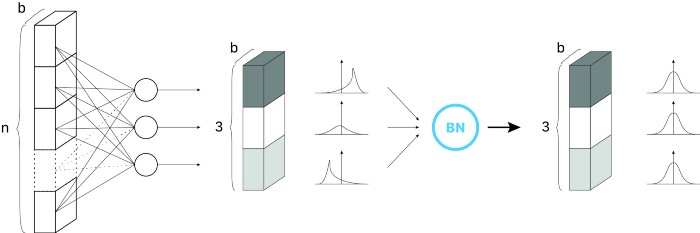

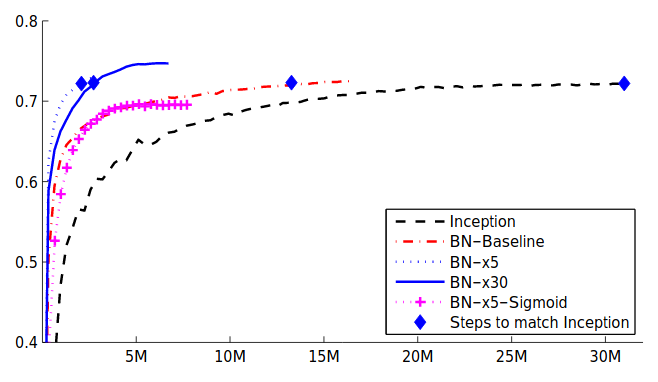

In [134]:
fashion_cnn = nn.Sequential(
    # 28x28 -> 14x14 after this layer
    nn.Conv2d(1, 64, stride=2, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    # 7x7 after this layer
    nn.Conv2d(64, 128, stride=2, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    
    # 4x4 after this layer
    nn.Conv2d(128, 256, stride=2, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    
    #2x2 after this layer
    nn.Conv2d(256, 512, stride=2, kernel_size=3, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    
    #1x10 after this layer
    nn.Conv2d(512, 10, stride=2, kernel_size=3, padding=1),
    nn.BatchNorm2d(10),
    
    # Turn into rank-1 tensor of 10 activations.
    Flatten()
)

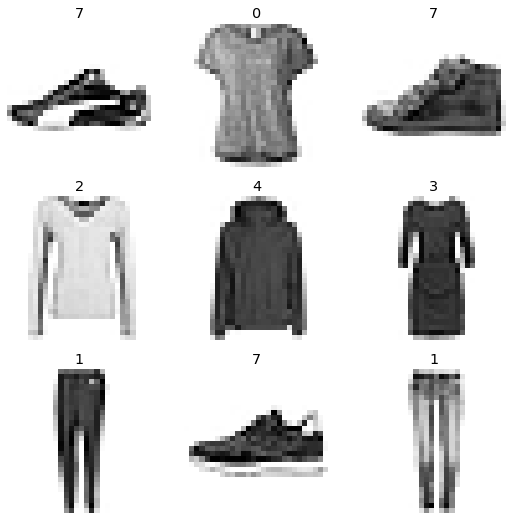

In [135]:
def get_fashion_dls(bs=512):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('train','test'),
        get_y=parent_label
    ).dataloaders(fashion_path, bs=bs)

fashion_dls = get_fashion_dls()
fashion_dls.show_batch()

In [142]:
fashion_learn = Learner(fashion_dls, fashion_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [137]:
fashion_learn.summary()

Sequential (Input shape: 512)
Layer (type)         Output Shape         Param #    Trainable 
                     512 x 64 x 14 x 14  
Conv2d                                    640        True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     512 x 128 x 7 x 7   
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     512 x 256 x 4 x 4   
Conv2d                                    295168     True      
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________________

SuggestedLRs(valley=0.0012022644514217973)

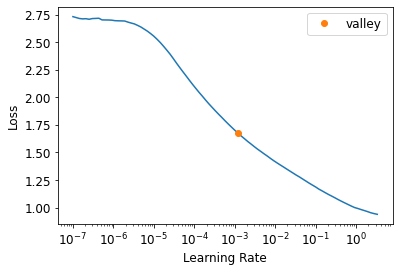

In [138]:
fashion_learn.lr_find()

## One Cycle Learning

- Increase learning rate
- Warmup to that learning rate
- Cool down gradually
- Larger learning rate will generalize better
- But we still want to converge

In [144]:
fashion_learn.fit_one_cycle(10, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.283428,0.600915,0.799000,00:15
1,0.280850,0.506120,0.826000,00:16
2,0.263232,0.315971,0.887200,00:16
3,0.234777,0.338488,0.871700,00:16
4,0.205486,0.318055,0.887500,00:16
5,0.172699,0.258602,0.911300,00:16
6,0.126120,0.243465,0.920400,00:16
7,0.076807,0.257492,0.924400,00:15
8,0.033807,0.262802,0.926900,00:16
9,0.016362,0.266731,0.928600,00:16


## Cats and Dogs

- Let's try Cats and Dogs Conv Net
- Differences
    - Larger images
    - Color!
- Bigger images -> more layers

In [170]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [193]:
pets_path = untar_data(URLs.PETS)
pets_path = pets_path/'images'

def is_cat(x): return x[0].isupper()

pets_dls = ImageDataLoaders.from_name_func(
    pets_path, get_image_files(pets_path), valid_pct=0.2, seed=42, 
    label_func=is_cat, item_tfms=Resize(224)
)

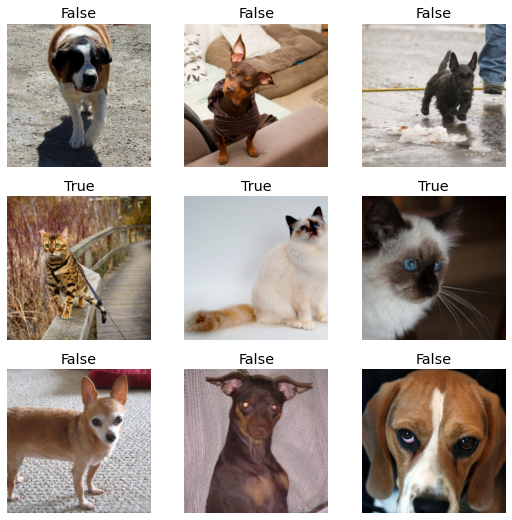

In [175]:
pets_dls.show_batch()

In [176]:
pets_cnn = nn.Sequential(
        conv(3, 32, ks=5),
        #112
        conv(32, 64),
        #56
        conv(64, 128),
        #28
        conv(128, 256),
        #14
        conv(256, 512),
        #7
        conv(512, 512),
        #4
        conv(512, 512),
        #2
        conv(512, 10, act=False),
        Flatten(),
    )

In [177]:
pets_learn = Learner(pets_dls, pets_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [178]:
pets_learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 112 x 112 
Conv2d                                    896        True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
Conv2d                                    18496      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 128 x 28 x 28  
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                                                           
___________________________________________________

SuggestedLRs(valley=0.00363078061491251)

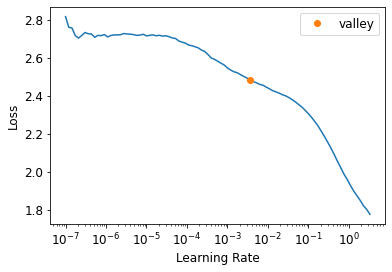

In [179]:
pets_learn.lr_find()

In [64]:
pets_learn.fit(10, 0.003)

epoch,train_loss,valid_loss,accuracy,time
0,0.020730,0.839546,0.828823,00:11
1,0.019753,0.495142,0.882273,00:10
2,0.017075,0.406522,0.890392,00:10
3,0.006907,0.435759,0.884980,00:10
4,0.009553,0.396425,0.890392,00:11
5,0.010133,0.466686,0.884980,00:11
6,0.015767,0.749516,0.843708,00:11
7,0.021242,0.602742,0.855210,00:10
8,0.014112,0.480521,0.882273,00:11
9,0.010783,0.522523,0.878890,00:11


In [74]:
resnet_learn = cnn_learner(dls, resnet18, metrics=error_rate, cbs=[ShowGraphCallback()])

In [75]:
resnet_learn.summary()

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 16 x 16   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

### Pooling Layers

- Another technique for reducing the number of parameters (downsampling)

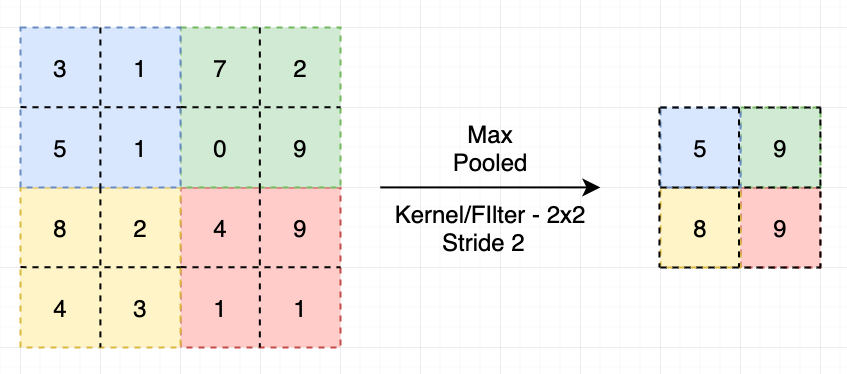

### Residuals

- Add shortcut connections that skip some layers
- ... that's it, really.

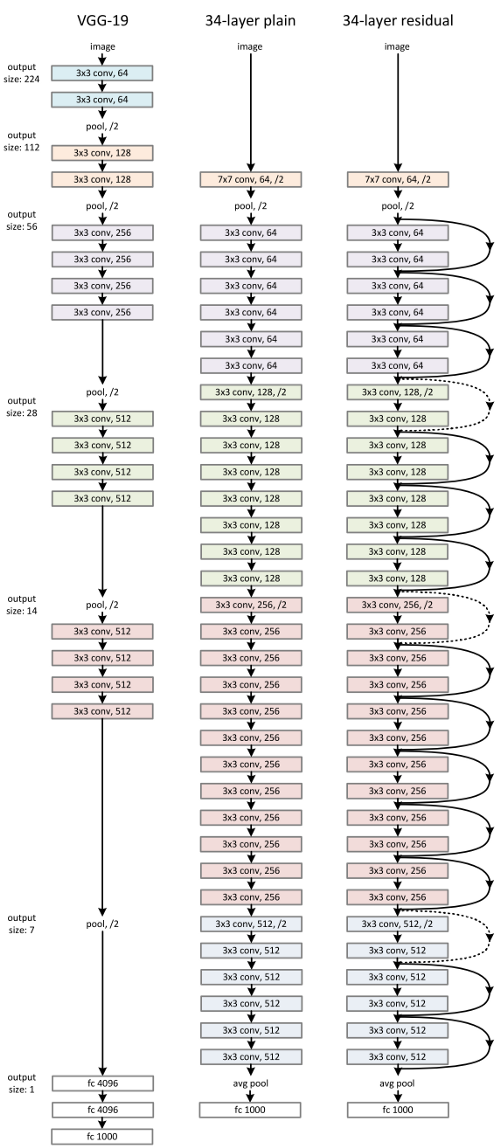

### Dropout

- Randomly remove connections during training
- Improves generalization

## Generating Images

- Deconvolutions
- z is the latent vector
    - Hidden layer with the fewest neurons
- Can be used to take a latent vector and generate and image
- More next time with... GANs!

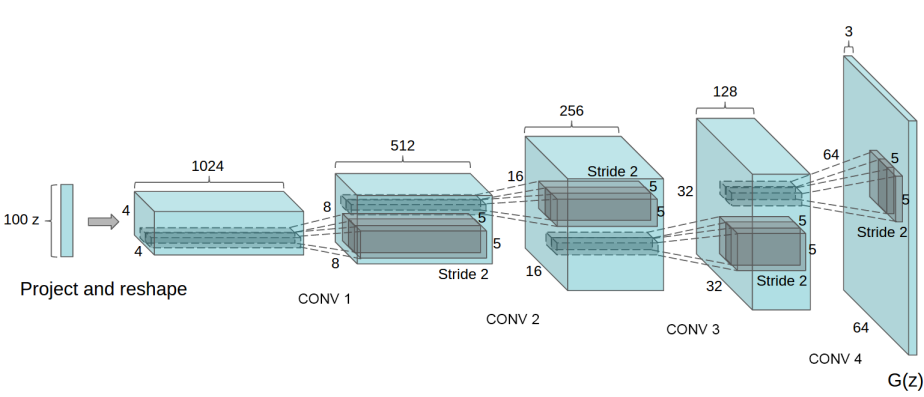

### The road to modern techniques

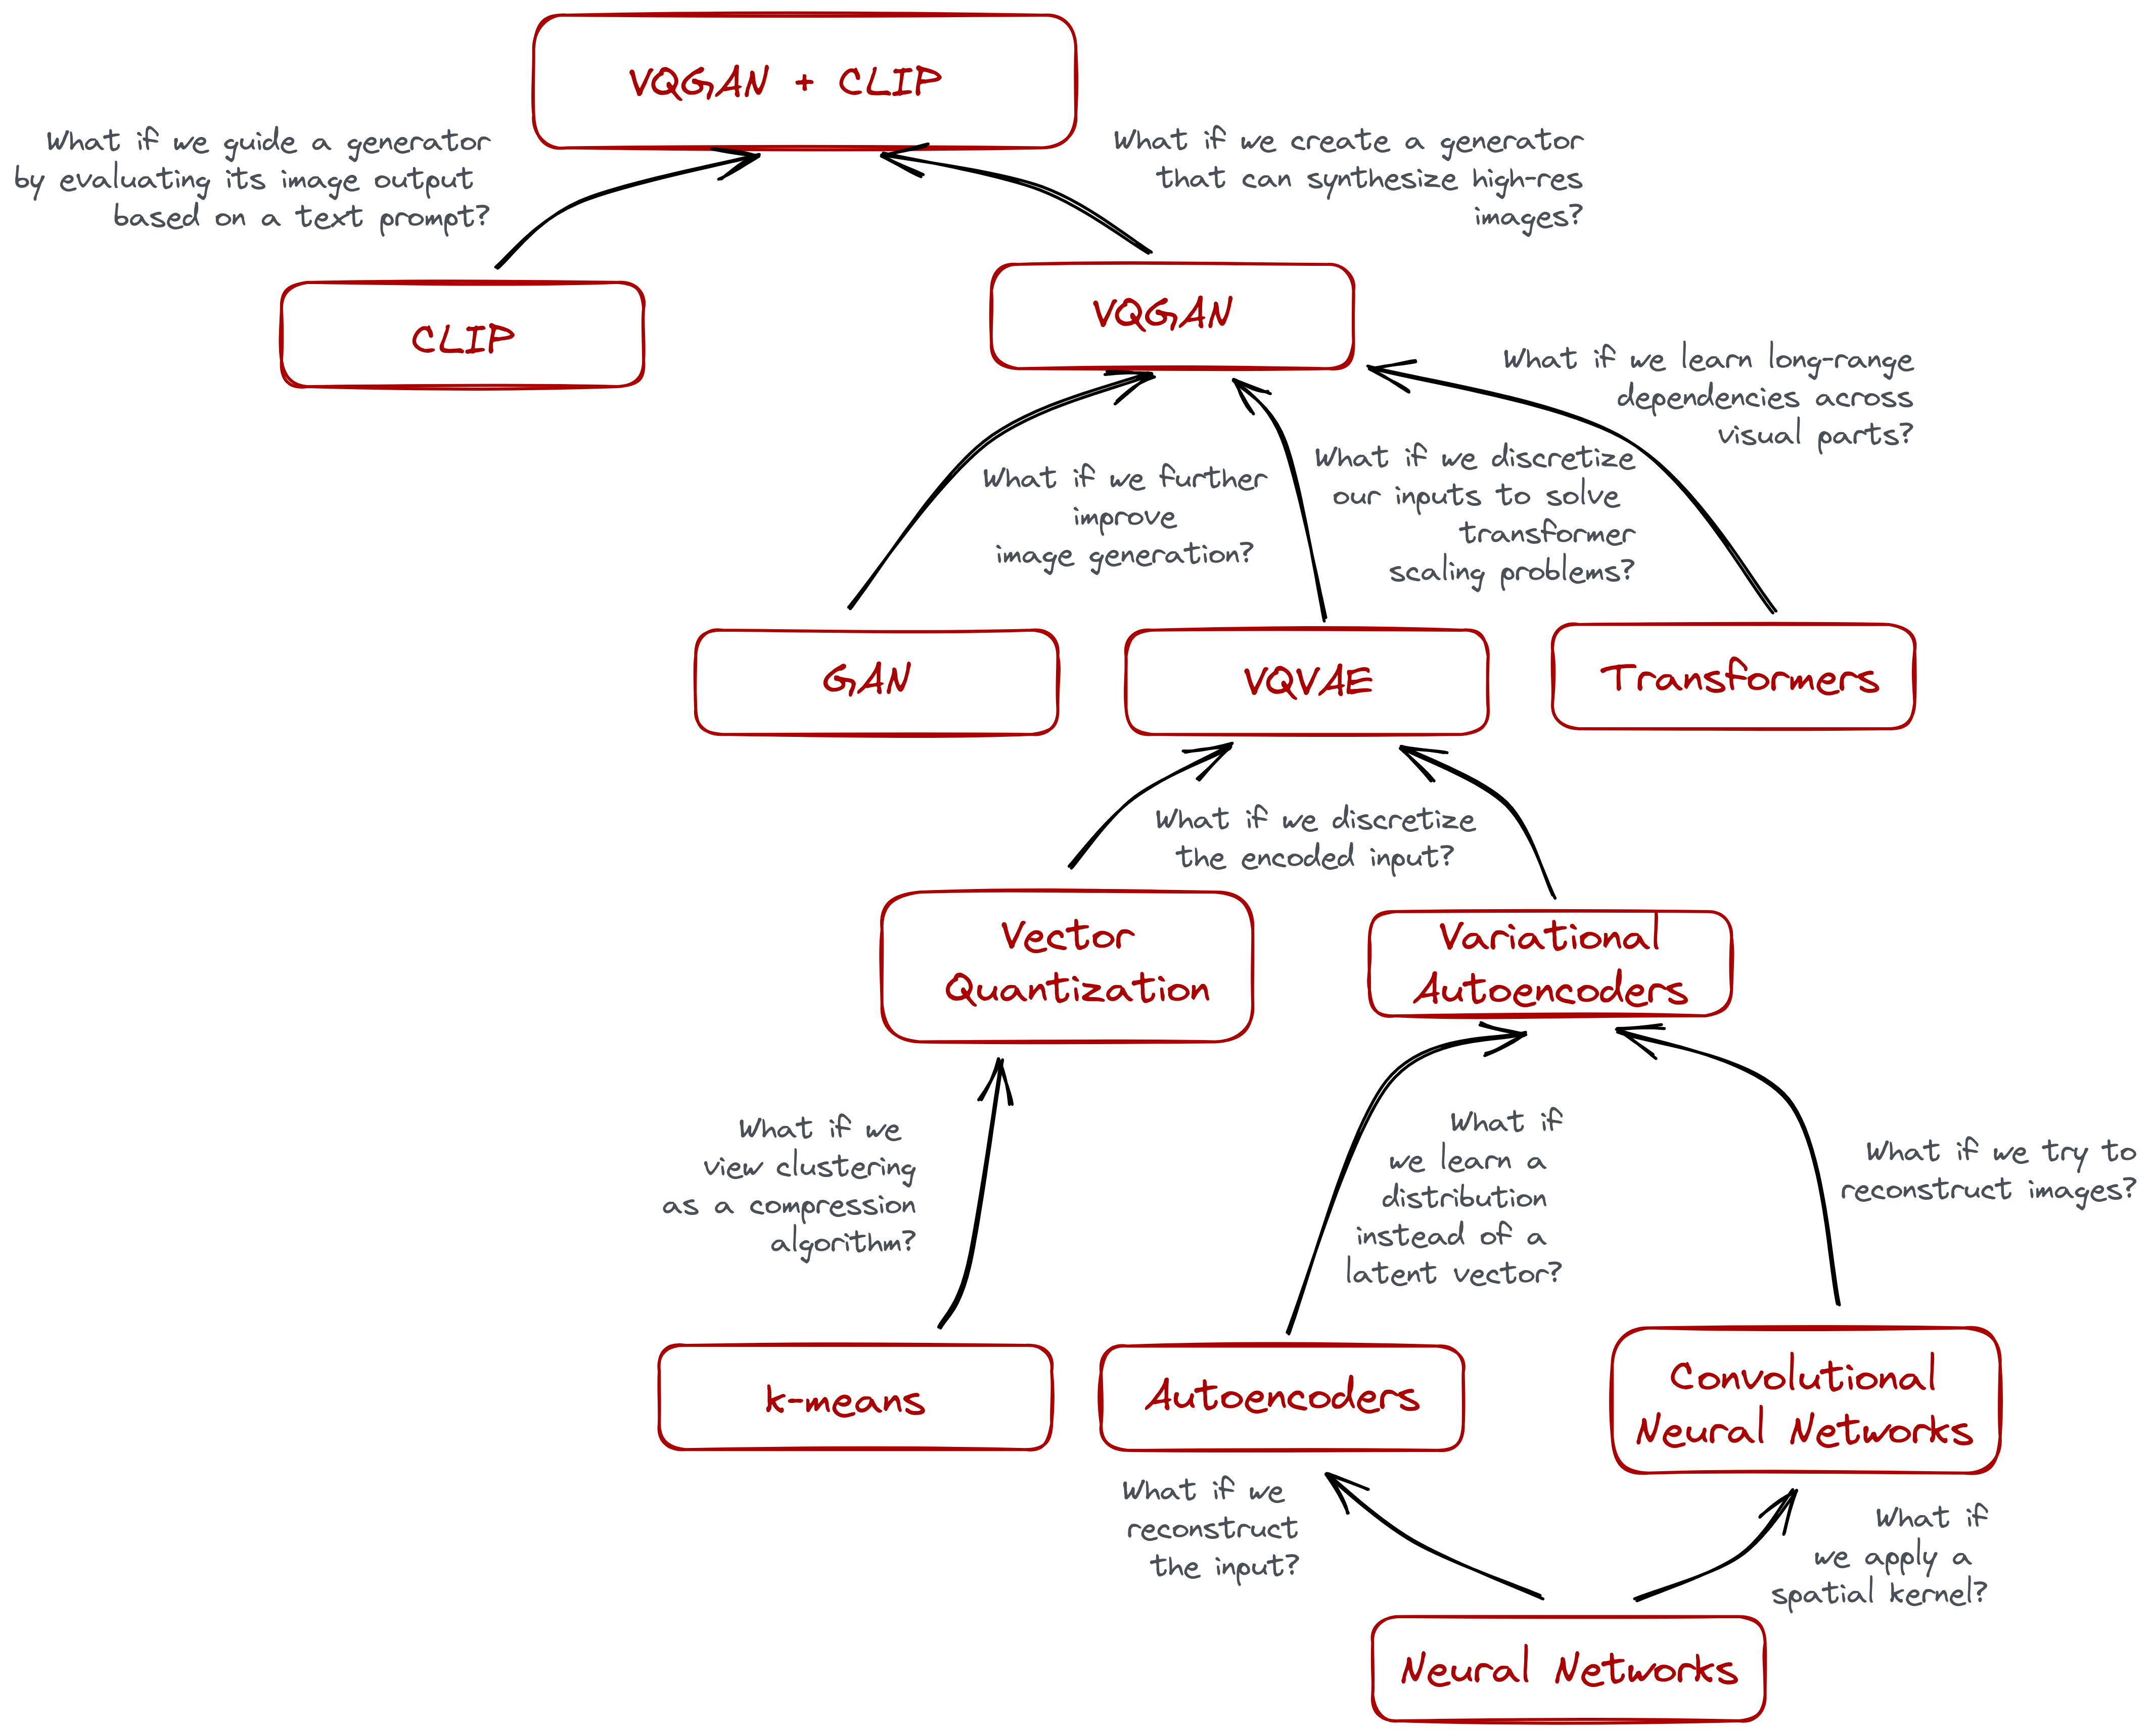

# 

https://colab.research.google.com/drive/1n_xrgKDlGQcCF6O-eL3NOd_x4NSqAUjK?usp=sharing

# Things to do

- Watch Coded Bias
    - free from PBS before Oct. 29 at https://www.pbs.org/independentlens/documentaries/coded-bias/
    - Also on Netflix
    - Write one paragraph summarizing the contents of the film
    - Write a one paragraph reaction
- Make sure you have an intuition for convolutions
- GANs and Lab 3 next time
    - Will also include your art submission
- Find something cool related to computer vision to show the class next week
    - Example Art machine is cool.